เชื่อม google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


ทำการสร้าง evaluation dataest ภาษาไทยโดยการใช้ LLM เเปลภาษา

In [ ]:
import requests
import time
import json
import os

# 🔑 API Key สำหรับ Together
api_key = "xxxxxxxxxxx"  # 👈 ใส่ Together API Key ของคุณตรงนี้

# 🚀 โหลดไฟล์คำถามพร้อม RAG Recommendations
input_file = '/content/drive/MyDrive/LockLearn/evaluation_datasetv2.json'  # ไฟล์ input
output_file = '/content/drive/MyDrive/LockLearn/evaluation_dataset_TH.json'  # ไฟล์ output

# 📂 โหลดข้อมูลจากไฟล์
with open(input_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"✅ รวมคำถามที่เลือกทั้งหมด: {len(data)}")

# 🚀 โหลดผลลัพธ์ล่าสุด (ถ้ามี)
if os.path.exists(output_file):
    with open(output_file, 'r', encoding='utf-8') as f:
        processed_answers = json.load(f)
        processed_ids = set([item['translated_question'] for item in processed_answers])
else:
    processed_answers = []
    processed_ids = set()

# 🔁 ฟังก์ชันเรียก API
def request_with_retry(prompt, retries=3, delay=5):
    headers = {"Content-Type": "application/json","Authorization": f"Bearer {api_key}"}
    json_data = {
        "model": "meta-llama/llama-4-scout-17b-16e-instruct",
        "messages": [{"role": "user", "content": prompt}]
    }

    for attempt in range(retries):
        try:
            response = requests.post("https://api.together.xyz/v1/chat/completions", headers=headers, json=json_data, timeout=30)
            if response.status_code == 200:
                return response.json()["choices"][0]["message"]["content"]
            elif response.status_code == 429:
                print("❌ Rate limit reached. Waiting for 10 seconds...")
                time.sleep(2)  # รอ 10 วินาทีถ้าเจอ rate limit
            else:
                print(f"❌ Error (Status {response.status_code}): {response.text}")
                time.sleep(delay)
        except requests.exceptions.RequestException as e:
            print(f"❌ Connection Error: {e}")
            time.sleep(delay)
    return None

# 🚀 แปลคำถามและคำตอบทั้งหมด
for index, item in enumerate(data, start=1):
    original_question = item['question']
    original_answer = item.get('answer', 'No answer provided')

    if original_question in processed_ids:
        continue

    # สร้าง prompt สำหรับแปลคำถามและคำตอบ
    question_prompt = f"Translate this question into Thai:\n\n{original_question}"
    answer_prompt = f"Translate this answer into Thai:\n\n{original_answer}"

    translated_question = request_with_retry(question_prompt)
    translated_answer = request_with_retry(answer_prompt)

    if translated_question and translated_answer:
        processed_answers.append({
            "translated_question": translated_question.strip(),
            "translated_answer": translated_answer.strip()
        })
        processed_ids.add(original_question)

        # 💾 บันทึกผลลัพธ์ทันที
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(processed_answers, f, ensure_ascii=False, indent=4)

        print(f"✅ คำถามและคำตอบที่ {index} ได้รับการแปลแล้ว")

print("✅ เสร็จสิ้นการแปลทั้งหมด")


ทำการ embed คำถาม

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import json
import os

# 🔧 กำหนดเส้นทางไฟล์
input_file = '/content/drive/MyDrive/LockLearn/evaluation_dataset_TH.json'
output_file = '/content/drive/MyDrive/LockLearn/evaluation_dataset_TH_embedded.json'

# 🚀 โหลดโมเดล Hugging Face
model_name = 'intfloat/multilingual-e5-large-instruct'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# 🚀 โหลดข้อมูลจากไฟล์
with open(input_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 🔥 ฟังก์ชันสร้าง Embedding
def create_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state.mean(dim=1)
    return embeddings[0].cpu().numpy().tolist()

# ✅ เริ่มสร้าง Embedding
print(f"✅ รวมคำถามทั้งหมด: {len(data)}")

for index, item in enumerate(data, start=1):
    text = item.get("translated_question", "")
    if text:
        item['question_embedding'] = create_embedding(text)
        print(f"✅ คำถามที่ {index} ได้รับการสร้าง Embedding แล้ว")

        # 💾 บันทึกผลลัพธ์ทันทีหลังสร้าง Embedding ของแต่ละคำถาม
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)

print("✅ เสร็จสิ้นการสร้าง Embedding ทั้งหมด")


เตรียมความพร้อมสู่การใช้ RAG ดึงคำตอบโดยการเช็คว่าเชื่อมกับ vector database ได้มั้ย

In [ ]:
import json
import chromadb

# 🚀 โหลด Evaluation Dataset พร้อม Embeddings
evaluation_file = '/content/drive/MyDrive/LockLearn/evaluation_dataset_TH_embedded.json'
with open(evaluation_file, 'r', encoding='utf-8') as f:
    evaluation_data = json.load(f)

print(f"✅ โหลด Evaluation Dataset พร้อม Embeddings จำนวนคำถาม-คำตอบ: {len(evaluation_data)}")

# 🚀 เชื่อมต่อกับ Chroma DB
db_path = '/content/drive/MyDrive/LockLearn/chromadb_database'
client = chromadb.PersistentClient(path=db_path)
collection = client.get_collection(name="recommendations")

# 🚀 ฟังก์ชัน RAG ดึงคำแนะนำที่ใกล้เคียง
def retrieve_recommendations(question_embedding, top_k=3):
    results = collection.query(
        query_embeddings=[question_embedding],
        n_results=top_k
    )
    if results['documents']:
        return results['documents'][0]
    return []

print("✅ พร้อมสำหรับการค้นหาคำแนะนำด้วย RAG")

# 🚀 ทดลองดึงคำแนะนำที่ใกล้เคียงสำหรับคำถามแรก
test_question = evaluation_data[0]['translated_question']
test_embedding = evaluation_data[0]['question_embedding']

recommendations = retrieve_recommendations(test_embedding)
print(f"\n🔎 คำถาม: {test_question}\n✅ คำแนะนำที่ใกล้เคียง:\n")

for idx, rec in enumerate(recommendations, 1):
    print(f"{idx}. {rec}")


ทำการใช้ RAG ดึงคำตอบที่ไกล้เคียงคำกับถามจากใน vector database

In [ ]:
import json
import chromadb

# 🚀 โหลด Evaluation Dataset พร้อม Embeddings
evaluation_file = '/content/drive/MyDrive/LockLearn/evaluation_dataset_TH_embedded.json'
with open(evaluation_file, 'r', encoding='utf-8') as f:
    evaluation_data = json.load(f)

print(f"✅ โหลด Evaluation Dataset พร้อม Embeddings จำนวนคำถาม-คำตอบ: {len(evaluation_data)}")

# 🚀 เชื่อมต่อกับ Chroma DB
db_path = '/content/drive/MyDrive/LockLearn/chromadb_database'
client = chromadb.PersistentClient(path=db_path)
collection = client.get_collection(name="recommendations")

# 🚀 ฟังก์ชัน RAG (Retrieve) เพื่อค้นหาคำแนะนำที่ใกล้เคียง
def retrieve_recommendations(query_embedding, top_k=3):
    results = collection.query(query_embeddings=[query_embedding], n_results=top_k)
    return results['documents'][0] if results['documents'] else []

# 🚀 ใช้ RAG ค้นหาคำแนะนำสำหรับทุกคำถามใน Dataset
rag_results = []

print("🔄 กำลังดึงคำแนะนำที่ใกล้เคียงด้วย RAG...")

for idx, item in enumerate(evaluation_data, 1):
    query_embedding = item.get('question_embedding')
    if not query_embedding:
        print(f"❌ ไม่มี Embedding สำหรับคำถามที่ {idx} - ข้ามไป")
        continue

    recommendations = retrieve_recommendations(query_embedding, top_k=3)

    rag_results.append({
        "translated_question": item.get('translated_question', ''),
        "translated_answer": item.get('translated_answer', ''),
        "category": item.get('category', ''),
        "recommendations": recommendations
    })

    if idx % 100 == 0 or idx == len(evaluation_data):
        print(f"✅ ประมวลผลแล้ว {idx}/{len(evaluation_data)} คำถาม")

# 🚀 บันทึกผลลัพธ์ RAG
rag_results_file = '/content/drive/MyDrive/LockLearn/evaluation_rag_results_TH.json'
with open(rag_results_file, 'w', encoding='utf-8') as f:
    json.dump(rag_results, f, ensure_ascii=False, indent=4)

print(f'✅ บันทึกผลลัพธ์ RAG ที่: {rag_results_file}')


ให้ LLM gen คำตอบที่เหมาะสมจากคำถาม

In [ ]:
import requests
import time
import json
import os

# 🔑 API Key สำหรับ Together
api_key = "xxxxxx"  # 👈 ใส่ Together API Key ของคุณตรงนี้

# 🚀 โหลดไฟล์คำถามพร้อม RAG Recommendations
input_file = '/content/drive/MyDrive/LockLearn/evaluation_rag_results_TH.json'
output_file = '/content/drive/MyDrive/LockLearn/optimized_answers_Llama4_scout_TH.json'

# 📂 โหลดข้อมูลจากไฟล์
with open(input_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 🚀 โหลดผลลัพธ์ล่าสุด (ถ้ามี)
if os.path.exists(output_file):
    with open(output_file, 'r', encoding='utf-8') as f:
        processed_answers = json.load(f)
        processed_ids = set([item['translated_question'] for item in processed_answers])
else:
    processed_answers = []
    processed_ids = set()

# 🔁 ฟังก์ชันเรียก API
def request_with_retry(json_data, retries=3, delay=5):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    for attempt in range(retries):
        try:
            response = requests.post("https://api.together.xyz/v1/chat/completions", headers=headers, json=json_data, timeout=30)
            if response.status_code == 200:
                answer = response.json()["choices"][0]["message"]["content"].strip()
                if len(answer) > 20:  # ตรวจสอบความยาวคำตอบ
                    return answer
            print(f"❌ Error (Status {response.status_code}): {response.text}")
            time.sleep(delay)
        except requests.exceptions.RequestException as e:
            print(f"❌ Connection Error: {e}")
            time.sleep(delay)
    return ""

# 🚀 ประมวลผลคำถามที่ยังไม่ได้ตอบ
for item in data:
    if item['translated_question'] in processed_ids:
        continue

    # สร้าง Prompt ที่ใช้คำถามและคำแนะนำภาษาไทย
    prompt = (
        f"คำถาม: {item['translated_question']}\n"
        f"คำแนะนำที่ได้รับ:\n"
    )

    for idx, rec in enumerate(item['recommendations'], 1):
        prompt += f"{idx}. {rec}\n"

    prompt += "โปรดเขียนคำตอบที่กระชับด้วยความให้กำลังใจ."

    json_data = {
        "model": "meta-llama/llama-4-scout-17b-16e-instruct",
        "messages": [{"role": "user", "content": prompt}]
    }

    answer = request_with_retry(json_data)

    if answer:
        processed_answers.append({
            "translated_question": item['translated_question'],
            "translated_answer": answer,
            "category": item['category']
        })
        processed_ids.add(item['translated_question'])

        # 💾 บันทึกผลลัพธ์ทันที
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(processed_answers, f, ensure_ascii=False, indent=4)

        print(f"✅ บันทึกคำตอบล่าสุด ({len(processed_answers)})")

print("✅ เสร็จสิ้นการประมวลผล")


เตรียมข้อมูล

In [ ]:
import json

# 🔧 เส้นทางไฟล์ (ภาษาไทย)
dataset_file = '/content/drive/MyDrive/LockLearn/evaluation_dataset_TH.json'
rag_results_file = '/content/drive/MyDrive/LockLearn/evaluation_rag_results_TH.json'
llm_answers_file = '/content/drive/MyDrive/LockLearn/optimized_answers_Llama4_scout_TH.json'

# 🚀 โหลดข้อมูล
with open(dataset_file, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

with open(rag_results_file, 'r', encoding='utf-8') as f:
    rag_results = json.load(f)

with open(llm_answers_file, 'r', encoding='utf-8') as f:
    llm_answers = json.load(f)

# ✅ คัดคำถามให้ตรงกัน (ภาษาไทย)
rag_questions = set(item['translated_question'] for item in rag_results)
filtered_dataset = [item for item in dataset if item['translated_question'] in rag_questions]
filtered_llm_answers = [item for item in llm_answers if item['translated_question'] in rag_questions]

print(f"✅ คำถามที่ตรงกันทั้งหมด: {len(filtered_dataset)}")


ใช้ LLM ในการ Judge โดยให้คะเเนน 0-5

In [ ]:
import requests
import time
import json

# 🔑 API Key สำหรับ Together
api_key = "xxxxxx"  # 👈 ใส่ Together API Key ของคุณตรงนี้

# 🔧 ฟังก์ชันเรียก API LLM Judge พร้อม Retry
def request_judgement_with_retry(prompt, retries=3, delay=5):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    json_data = {
        "model": "meta-llama/llama-4-scout-17b-16e-instruct",
        "messages": [{"role": "user", "content": prompt}]
    }

    for attempt in range(retries):
        try:
            response = requests.post("https://api.together.xyz/v1/chat/completions", headers=headers, json=json_data, timeout=30)
            if response.status_code == 200:
                answer = response.json()["choices"][0]["message"]["content"].strip()
                return answer
            print(f"❌ Error (Status {response.status_code}): {response.text}")
            time.sleep(delay)
        except requests.exceptions.RequestException as e:
            print(f"❌ Connection Error: {e}")
            time.sleep(delay)
    return ""

# 🔧 เส้นทางไฟล์ (ภาษาไทย)
dataset_file = '/content/drive/MyDrive/LockLearn/evaluation_dataset_TH.json'
rag_results_file = '/content/drive/MyDrive/LockLearn/evaluation_rag_results_TH.json'
llm_answers_file = '/content/drive/MyDrive/LockLearn/optimized_answers_Llama4_scout_TH.json'

# 🚀 โหลดข้อมูล
with open(dataset_file, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

with open(rag_results_file, 'r', encoding='utf-8') as f:
    rag_results = json.load(f)

with open(llm_answers_file, 'r', encoding='utf-8') as f:
    llm_answers = json.load(f)

# ✅ คัดคำถามให้ตรงกัน
rag_questions = set(item['translated_question'] for item in rag_results)
filtered_dataset = [item for item in dataset if item['translated_question'] in rag_questions]
filtered_llm_answers = [item for item in llm_answers if item['translated_question'] in rag_questions]

print(f"✅ คำถามที่ตรงกันทั้งหมด: {len(filtered_dataset)}")

# 🚀 ประเมินคำถามแต่ละข้อ
judgement_results = []

for idx, rag_item in enumerate(rag_results, 1):
    question = rag_item['translated_question']
    recommendations = rag_item['recommendations']
    llm_answer = next((ans['translated_answer'] for ans in filtered_llm_answers if ans['translated_question'] == question), "")
    ground_truth = next((item['translated_answer'] for item in filtered_dataset if item['translated_question'] == question), "")

    # สร้าง Prompt ให้ LLM Judge
    prompt = (
        f"Question: {question}\n"
        f"Ground Truth Answer: {ground_truth}\n"
        f"RAG Recommendations: {', '.join(recommendations)}\n"
        f"LLM Answer: {llm_answer}\n"
        "Score the quality of the RAG recommendations (0-5) and the LLM answer (0-5), provide reasoning."
    )

    judgement = request_judgement_with_retry(prompt)
    print(f"✅ คำถามที่ {idx} ได้รับการประเมินแล้ว")

    judgement_results.append({
        "question": question,
        "ground_truth": ground_truth,
        "recommendations": recommendations,
        "llm_answer": llm_answer,
        "judgement": judgement
    })

    # 💾 บันทึกผลลัพธ์ทันที
    output_file = '/content/drive/MyDrive/LockLearn/evaluation_judgement_results_TH.json'
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(judgement_results, f, ensure_ascii=False, indent=4)

print(f"✅ ประเมินเสร็จสิ้น บันทึกผลลัพธ์ที่: {output_file}")


เอาคะเเนนที่ได้มารวมกันเเล้วเปรียบเทียบ

✅ จำนวนคำถามที่ประเมิน: 1186
✅ คะแนนเฉลี่ยของ RAG: 75.70%
✅ คะแนนเฉลี่ยของ LLM: 89.16%


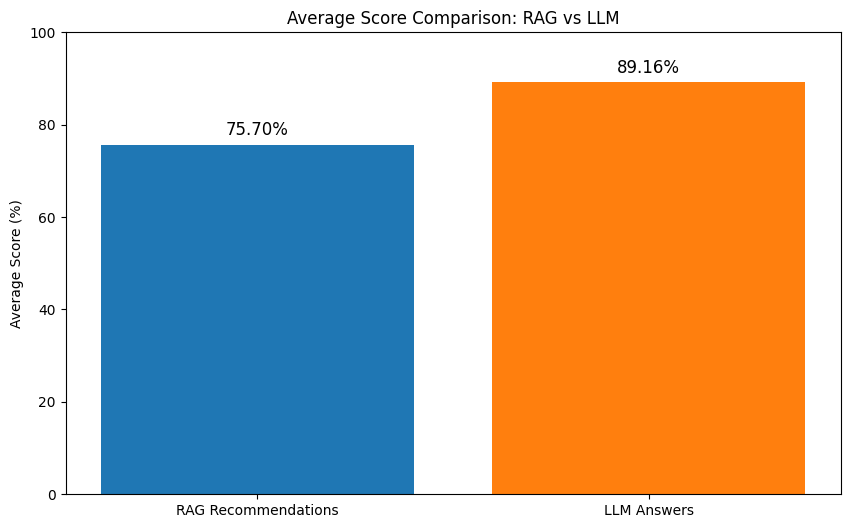

In [3]:
import json
import re
import matplotlib.pyplot as plt

# 📂 โหลดไฟล์ผลลัพธ์การประเมิน
judgement_results_file = '/content/drive/MyDrive/LockLearn/evaluation_judgement_results_TH.json'

with open(judgement_results_file, 'r', encoding='utf-8') as f:
    judgement_results = json.load(f)

# ✅ ฟังก์ชันเพื่อแยกคะแนนจาก judgement
def extract_scores(judgement_text):
    rag_score = llm_score = None

    # ใช้ Regular Expression เพื่อดึงคะแนน
    rag_match = re.search(r"RAG Recommendations Score: (\d)", judgement_text)
    llm_match = re.search(r"LLM Answer Score: (\d)", judgement_text)

    if rag_match:
        rag_score = int(rag_match.group(1))
    if llm_match:
        llm_score = int(llm_match.group(1))

    return rag_score, llm_score

# ✅ สร้างข้อมูลใหม่พร้อมคะแนน
processed_results = []
for item in judgement_results:
    rag_score, llm_score = extract_scores(item.get('judgement', ''))

    if rag_score is not None and llm_score is not None:
        processed_results.append({
            "rag_score": rag_score,
            "llm_score": llm_score
        })

# ✅ คำนวณคะแนนเฉลี่ย
total_rag_score = sum(item['rag_score'] for item in processed_results)
total_llm_score = sum(item['llm_score'] for item in processed_results)
num_questions = len(processed_results)

avg_rag_score = (total_rag_score / (num_questions * 5)) * 100  # เปลี่ยนเป็นเปอร์เซ็นต์
avg_llm_score = (total_llm_score / (num_questions * 5)) * 100  # เปลี่ยนเป็นเปอร์เซ็นต์

# ✅ แสดงผลคะแนน
print(f"✅ จำนวนคำถามที่ประเมิน: {num_questions}")
print(f"✅ คะแนนเฉลี่ยของ RAG: {avg_rag_score:.2f}%")
print(f"✅ คะแนนเฉลี่ยของ LLM: {avg_llm_score:.2f}%")

# ✅ สร้างกราฟ Average Score
labels = ['RAG Recommendations', 'LLM Answers']
scores = [avg_rag_score, avg_llm_score]
colors = ['#1f77b4', '#ff7f0e']

plt.figure(figsize=(10, 6))
plt.bar(labels, scores, color=colors)
plt.title('Average Score Comparison: RAG vs LLM')
plt.ylabel('Average Score (%)')
plt.ylim(0, 100)

# 🔧 แสดงคะแนนบนกราฟ
for i, score in enumerate(scores):
    plt.text(i, score + 2, f"{score:.2f}%", ha='center', fontsize=12)

plt.show()


เปรียบเทียบค่า accuracy โดยเอาเเค่ Score ≥ 4

✅ จำนวนคำถามที่ประเมิน: 1186
✅ RAG Accuracy: 83.31% (988/1186)
✅ LLM Accuracy: 92.58% (1098/1186)


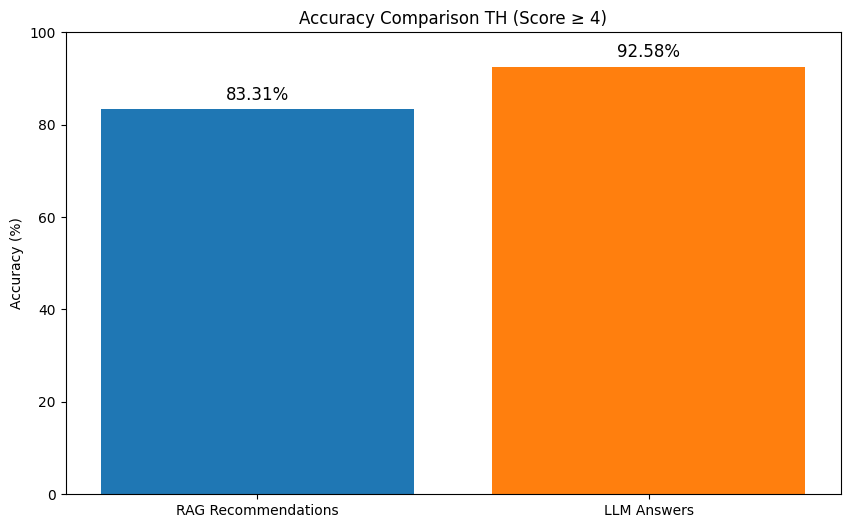

In [4]:
import json
import re
import matplotlib.pyplot as plt

# 📂 โหลดไฟล์ผลลัพธ์การประเมิน
judgement_results_file = '/content/drive/MyDrive/LockLearn/evaluation_judgement_results_TH.json'

with open(judgement_results_file, 'r', encoding='utf-8') as f:
    judgement_results = json.load(f)

# ✅ ฟังก์ชันเพื่อแยกคะแนนจาก judgement
def extract_scores(judgement_text):
    rag_score = llm_score = None

    # ใช้ Regular Expression เพื่อดึงคะแนน
    rag_match = re.search(r"RAG Recommendations Score: (\d)", judgement_text)
    llm_match = re.search(r"LLM Answer Score: (\d)", judgement_text)

    if rag_match:
        rag_score = int(rag_match.group(1))
    if llm_match:
        llm_score = int(llm_match.group(1))

    return rag_score, llm_score

# ✅ สร้างข้อมูลใหม่พร้อมคะแนน
processed_results = []
for item in judgement_results:
    rag_score, llm_score = extract_scores(item.get('judgement', ''))

    if rag_score is not None and llm_score is not None:
        processed_results.append({
            "rag_score": rag_score,
            "llm_score": llm_score
        })

# ✅ คำนวณ Accuracy (คะแนน ≥ 4 ถือว่าถูกต้อง)
num_questions = len(processed_results)
correct_rag = sum(1 for item in processed_results if item['rag_score'] >= 4)
correct_llm = sum(1 for item in processed_results if item['llm_score'] >= 4)

rag_accuracy = (correct_rag / num_questions) * 100
llm_accuracy = (correct_llm / num_questions) * 100

# ✅ แสดงผล Accuracy
print(f"✅ จำนวนคำถามที่ประเมิน: {num_questions}")
print(f"✅ RAG Accuracy: {rag_accuracy:.2f}% ({correct_rag}/{num_questions})")
print(f"✅ LLM Accuracy: {llm_accuracy:.2f}% ({correct_llm}/{num_questions})")

# ✅ สร้างกราฟ Accuracy
labels = ['RAG Recommendations', 'LLM Answers']
accuracy_scores = [rag_accuracy, llm_accuracy]
colors = ['#1f77b4', '#ff7f0e']

plt.figure(figsize=(10, 6))
plt.bar(labels, accuracy_scores, color=colors)
plt.title('Accuracy Comparison TH (Score ≥ 4)')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

# 🔧 แสดงค่า Accuracy บนกราฟ
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 2, f"{acc:.2f}%", ha='center', fontsize=12)

plt.show()
